#### Index
- [Data Loading](#Data-loading)
- [Data Cleanup](#Data-Cleanup)
  - [Understand the Genre](#Understand-the-Genre)
  - [Correct numbers and dates](#Correct-numbers-and-dates)
  - [Analyze reviews](#Analyze-reviews)
- [Create final Data set](#Create-final-Data-set)
  - [Add Genre Model based on common type groupings](#Add-Genre-Model-based-on-common-type-groupings)
  - [Calculate metrics to understand the activity](#Calculate-metrics-to-understand-the-activity)
- [Split the data](#Split-the-data)
  - [Remove extra fields](#Remove-extra-fields)
- [Data Models](#Data-Models)

In [2]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sb 


#Stats modeling 

from sklearn.pipeline import Pipeline


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

from datetime import date


from sklearn import set_config
from warnings import filterwarnings 
filterwarnings('ignore')


[Back to top](#Index)

### Data loading

In [3]:
#Load game data
gamesDF = pd.read_csv('data/games.csv')
gamesDF.describe()

,Unnamed: 0,Rating
count,1512.000000,1499.000000
mean,755.500000,3.719346
std,436.621117,0.532608
min,0.000000,0.700000
25%,377.750000,3.400000
50%,755.500000,3.800000
75%,1133.250000,4.100000
max,1511.000000,4.800000


In [4]:
gamesDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1512 non-null   int64  
 1   Title              1512 non-null   object 
 2   Release Date       1512 non-null   object 
 3   Team               1511 non-null   object 
 4   Rating             1499 non-null   float64
 5   Times Listed       1512 non-null   object 
 6   Number of Reviews  1512 non-null   object 
 7   Genres             1512 non-null   object 
 8   Summary            1511 non-null   object 
 9   Reviews            1512 non-null   object 
 10  Plays              1512 non-null   object 
 11  Playing            1512 non-null   object 
 12  Backlogs           1512 non-null   object 
 13  Wishlist           1512 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 165.5+ KB


[Back to top](#-Index)


### Data Cleanup

In [5]:
gamesDF['reldate'] = gamesDF['Release Date']


end_of_collection = pd.to_datetime(pd.Series(['3/19/2023']))[0]


In [6]:

filterDF = gamesDF.query("reldate != 'releases on TBD'")

filterDF['reldate'] = pd.to_datetime(filterDF['reldate'])

#Remove games that had not released at time of data collection
filterDF = filterDF[filterDF['reldate'] <= end_of_collection]
filterDF.describe()

,Unnamed: 0,Rating,reldate
count,1497.000000,1497.000000,1497
mean,753.387442,3.718236,2012-08-15 09:51:34.989980160
min,0.000000,0.700000,1980-05-22 00:00:00
25%,374.000000,3.400000,2007-09-13 00:00:00
50%,755.000000,3.800000,2014-07-26 00:00:00
75%,1131.000000,4.100000,2019-08-29 00:00:00
max,1511.000000,4.600000,2023-03-17 00:00:00
std,437.388222,0.532018,NaN


In [7]:
filterDF.reset_index(inplace=True)
filterDF.drop(columns=['Unnamed: 0','index'], axis=1, inplace=True)



In [8]:
#remove all [] - we do not need these to indicate the fields are a collection of strings.
filterDF['Team']= filterDF['Team'].str.replace("\[",'').str.replace('\]','')
filterDF['Genres']= filterDF['Genres'].str.replace("\[",'').str.replace('\]','')
filterDF['Reviews']= filterDF['Reviews'].str.replace("\[",'').str.replace('\]','')


[Back to top](#Index)

#### Understand the Genre
Separate out mixed genres to mark genres separately.

In [9]:
genreList = []

In [10]:
genreList = filterDF['Genres'].str.split(',')

In [11]:
#separate the string into the elements and remove extra characters
result = list({x for l in genreList for x in l})
genre=[]
for i in result:
    genre.append(i.lstrip())
    
genre = [x.strip("']") for x in genre]
genre = [x.strip("['") for x in genre]
# using remove() to remove empty strings
while("" in genre):
    genre.remove("")
#convert to set to eliminate dups.
genreSet= set(genre)


In [12]:
#return 1 for each string in the series that contains match
def match_string(str_series, match):
    if str_series.find(match) == -1:
        return 0
    else:
        return 1



In [13]:
newDF= pd.DataFrame(columns=list(genreSet))

In [14]:
#Create a column in filterDF for each genre,
#Cycle through the filterDF and mark for each game that is specific genre

for i in list(genreSet):

    newDF[i] = filterDF['Genres'].apply(match_string,  match=i)



    

[Back to top](#Index)

#### Correct numbers and dates
Fix the data so that all numbers are converted from strings to numbers

In [15]:
#Fix Times listed and Number of reviews
def convert_to_num(x):
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    return float(x)

In [16]:
filterDF['listings'] = filterDF['Times Listed'].apply(convert_to_num)
filterDF['review_count'] = filterDF['Number of Reviews'].apply(convert_to_num)
filterDF['played'] = filterDF['Plays'].apply(convert_to_num)
filterDF['playing'] = filterDF['Playing'].apply(convert_to_num)
filterDF['backlog'] = filterDF['Backlogs'].apply(convert_to_num)
filterDF['wishlist'] = filterDF['Wishlist'].apply(convert_to_num)


[Back to top](#Index)

#### Analyze reviews
Each game contains a sampling of reviews.  From these reveiws, collect the number of positive and negative sentiment.

##### Parse Text
The current lists are not separated. Split on the ','

In [17]:
reviewsList = filterDF['Reviews'].str.split(',')



##### Analyze the reviews and mark the sentiment 
Now remove the stop words and tag for sentiment.

Known issue here: some reviews are in spanish.

For this model, we picked a rating of 3.8 or greater as "good" and below 3.8 as bad.  This is an assumption based on the data distribution and the knowledge that user facing systems break reviews into 3+ or 4+ as good.  


In [ ]:
good = 3.8

##### Import text analysis and setup functions for processing the reviews

In [18]:

import nltk   
# download the stopwords for the process function
nltk.download('stopwords')

import re                                  # library for regular expression operations
import string                              # for string operations

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # module for identifying positive and negative sentiment

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ryd_d\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ryd_d\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [19]:
## process the reviews
 # review is string
def process_reviews(review):
   
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(review)

    tweets_clean = tweet_tokens
    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english) and (word not in string.punctuation):  # remove stop words and punctuation
            tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

In [20]:
## Process the reviews based on the product ratings and their word sentiment score

def build_freqs(tweets, ylist):
    #tweets - list of reviews or tweets
    #ylist - list of overall product rating
    sid= SentimentIntensityAnalyzer() 
    freqs = {}
    pos = []
    neg = []

    for y, tweet in zip(ylist, tweets):
        for word in process_reviews(tweet):
            
            if (y >= good):
                #+ sid.polarity_scores(word)['compound']) >= good:
                pair = (word, 1)
            else:
                pair = (word, -1)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
                if (y >= good):
                    pos.append(word)
                else:
                    neg.append(word)
    
    # freqs: a dictionary mapping each (word, rating, sentiment)  to its frequency
    
    return freqs, pos, neg                   

In [21]:
## Tokenize tweets and update the freq list
 # tweet - review text as string
def extract_features(tweet, freqs):
    
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_reviews(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
       
    # loop through each word in the list of words
    for word in word_l:
         
        if (word,1.0) in freqs:
            # increment the word count for the positive label 1
            x[0,1] += freqs[(word,1.0)]
        if(word,-1.0) in freqs:
            # increment the word count for the negative label 0
            x[0,2] += freqs[(word,-1.0)]

        
    return x

In [22]:
#Setup ratings to mirror the split so we know the overall sentiment for the reviews combined scoring.
ratings = []
reviews = []


sia = SentimentIntensityAnalyzer()



#cycle through the list
for i in range(0,len(reviewsList)):
    # Clear old scored values
    scored=[]
    #analyze the sentiment for each review per game.
    for j in range(0, len(reviewsList[i])):
        if reviewsList[i][j] =='':
           "" #skip
        else:
            #append the rating of the score, add the reivew and the rating.
            scored.append(sia.polarity_scores(reviewsList[i][j]))
            reviews.append(reviewsList[i][j])
            ratings.append(filterDF['Rating'][i])



In [23]:
# create frequency dictionary
freqs, pos, neg = build_freqs(reviews,ratings)

In [24]:
#Remove all words that got both good rating and bad rating.
common_set = set(pos).intersection(neg)


In [25]:
for word in common_set:
    del freqs[(word, 1)]
    del freqs[(word,-1)]


In [26]:
#Change from rating to good or bad based on value in good
y_full = filterDF['Rating'].apply(lambda x : f"1" if x >= good else f"0")
X_full = filterDF.drop(columns=['Rating', 'Genres', 'Times Listed', 'Number of Reviews','reldate'], axis =1)


In [27]:
sentiment_x = X_full[['Reviews']]

In [28]:


# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(sentiment_x), 3))
for i in range(len(sentiment_x)):
    X[i, :]= extract_features(sentiment_x.iat[i,0], freqs)
    

my_words = process_reviews(sentiment_x.iat[0,0])

In [29]:
#unpack and review words
mywords = []
myscore = []
for key in freqs.keys():
    keys = key
    mywords.append(key[0])
    myscore.append(key[1])



[Back to top](#Index)

### Create final Data set

Add review sentiment
Create a copy without the genre data
Create a copy with genre data and genre groupings

In [30]:
X_full['positive'] = X[:,1]
X_full['negative'] =  -X[:,2]


In [31]:
X_simple = X_full.copy(deep=False)
#Keep simple metrics for use without genres

[Back to top](#Index)

#### Add Genre Model based on common type groupings

In [32]:
def validate_from_list(x):
    #from a df with multiple columns (x)
    #Return 1 if all the columns have 1 and -1 otherwise
    combolist=[]
    notZero = 1
    for i in range (0, x.shape[0]):
        notZero = 1
        
        for j in range (0, x.shape[1]):
            if notZero == -1:
                notZero = -1
            else:
                if x.iat[i,j] == -1:
                    notZero = -1
                else:
                    notZero = 1
        combolist.append(notZero)

    return combolist

In [33]:
#Group Genres by simple types
#racing & simulator
X_full['racSim_games'] = newDF['Racing']+newDF['Simulator']

#Game often found in arcade: pinball & arcade
X_full['arc_games'] = newDF['Pinball']+newDF['Arcade']

#strategic games: tactical, real time, strategy, simulator, moba, turn-based
X_full['strat_games'] = newDF['Tactical']+newDF['Strategy']+newDF['Real Time Strategy']+newDF['Turn Based Strategy']+newDF['Simulator']+newDF['MOBA']

#puzzle/analytic games: quiz, puzzle, point, card
X_full['puz_games'] = newDF['Puzzle']+newDF['Quiz/Trivia']+newDF['Point-and-Click']+newDF['Card & Board Game']


#VS games with an element of fight - sport, fighting, brawler
X_full['fight_vs_games'] = newDF['Brawler']+newDF['Fighting']+newDF['Shooter']+newDF['Sport']

#Non-standard games: indie, visual novel, point 
X_full['uncommon_games'] = newDF['MOBA']+newDF['Indie']+newDF['Visual Novel']



#Find all Adventure based RPGs
X_full['advRPG'] = validate_from_list(newDF.filter(['Adventure','RPG'], axis=1))
#Find all Strategy RPGs
X_full['stratRPG'] = validate_from_list(newDF.filter(['strat_games','RPG'], axis=1))






[Back to top](#Index)

#### Calculate metrics to understand the activity


In [34]:


# Manually create expanded values.
X_full['positive_sq'] = X[:,1]**2
X_full['negative_sq'] = -(X[:,2]**2)

In [35]:
#add age and ratio of age to metrics

X_full['age'] = (end_of_collection - pd.to_datetime(filterDF['reldate'])).dt.days


In [36]:
X_full['listings per day'] = X_full['listings']/X_full['age']
X_full['reviews per day'] = X_full['review_count']/X_full['age']
X_full['invplays per day'] = -(X_full['played'])/X_full['age']
X_full['backlog per day'] = X_full['backlog']/X_full['age']
X_full['invplayed'] = -X_full['played']

In [37]:
#Combining the list and review counts did not impact the total
X_full['listandrev']=-X_full['listings']*X_full['review_count']
X_full['larsq']=X_full['listandrev']**2

#Combine the list and wishlist
X_full['listandwish']=-X_full['listings']*X_full['wishlist']
X_full['lawsq']=X_full['listandwish']**2


#Combine list, review, and wish
X_full['listrevwish']=-X_full['listings']*X_full['review_count']*X_full['wishlist']
X_full['lrw']=X_full['listrevwish']**2


In [38]:
#Sq and Cube any values that were above 1 for impact
X_full['ilsq']=-X_full['listings']**2
X_full['lcub']=X_full['listings']**3
X_full['rsq']=X_full['review_count']**2
X_full['rcub']=X_full['review_count']**3
X_full['invwsq']=-X_full['wishlist']**2
X_full['wcub']=X_full['wishlist']**3


X_full['ppd_sq'] = (X_full['invplays per day'] **2)
X_full['inv_ppd_cub'] = -(X_full['invplays per day'] **3)



In [39]:
#Inv negative coorelations and remove original from view
X_full['invplayed']=-X_full['played']
X_full['invbacklog'] =-X_full['backlog']
X_full['invage']=-X_full['age']

In [40]:
X_full.drop(columns=['played','backlog','age'], axis =1, inplace=True)


In [41]:
#Now add the genre
X_full = X_full.join(newDF)

In [42]:
X_full['genres_Sum'] = X_full['Adventure']+  X_full['Arcade']+ X_full['Brawler']+ X_full['Card & Board Game'] +     X_full['Fighting']+  X_full['Indie']+     X_full['MOBA'] +     X_full['Music']+      X_full['Pinball']+\
      X_full['Platform']+ X_full['Point-and-Click']+      X_full['Puzzle']+ X_full['Quiz/Trivia']+\
      X_full['RPG']+ X_full['Racing']+  X_full['Real Time Strategy']+ X_full['Shooter']+ X_full['Simulator']+     X_full['Sport']+      X_full['Strategy']+\
      X_full['Tactical']+   X_full['Turn Based Strategy']+ X_full['Visual Novel']

[Back to top](#Index)

### Split the data

In [43]:
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y_full, 
                                                   random_state = 42)

In [44]:
X_simple_train_full, X_simple_test_full, y_train, y_test = train_test_split(X_simple, y_full, 
                                                   random_state = 42)

[Back to top](#Index)

#### Remove extra fields

In [45]:
X_train = X_train_full.drop(columns=['Title', 'Release Date', 'Team', 'Summary','Reviews', 
                                     'Plays', 'Playing', 'Backlogs', 
                                    'Wishlist'], axis =1)
X_test = X_test_full.drop(columns=['Title', 'Release Date', 'Team', 'Summary','Reviews',
                                  'Plays', 'Playing', 'Backlogs', 
                                    'Wishlist'], axis =1)


In [46]:
X_simple_train = X_simple_train_full.drop(columns=['Title', 'Release Date', 'Team', 'Summary','Reviews', 
                                     'Plays', 'Playing', 'Backlogs', 
                                    'Wishlist'], axis =1)
X_simple_test = X_simple_test_full.drop(columns=['Title', 'Release Date', 'Team', 'Summary','Reviews',
                                  'Plays', 'Playing', 'Backlogs', 
                                    'Wishlist'], axis =1)


[Back to top](#Index)


### Data Models
Setup test models to see which models will be best able to predict which aspects inidcate long term game success.

In [47]:
transformer = StandardScaler()

In [48]:
#KNN
#Range of variables
paramsKNN={'knn__n_neighbors': range(2,25)}

#Create pipe
knn_pipe = Pipeline([('transform', transformer), 
                             ('knn', KNeighborsClassifier())])




In [49]:


#Create grid to search best variables with genre
model_knn = GridSearchCV(estimator=knn_pipe,param_grid=paramsKNN, scoring='accuracy',
                         return_train_score=True)



In [50]:


#Create grid to search best variables on simple
model_simple_knn = GridSearchCV(estimator=knn_pipe,param_grid=paramsKNN, scoring='accuracy',
                         return_train_score=True)


In [51]:
#fit variables
model_knn.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transform', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': range(2, 25)},
             return_train_score=True, scoring='accuracy')

In [52]:
#fit variables
model_simple_knn.fit(X_simple_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transform', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': range(2, 25)},
             return_train_score=True, scoring='accuracy')

In [53]:
#Genre analysis
best_dtc = list(model_knn.best_params_.values())
best_acc = model_knn.score(X_test, y_test)

print(model_knn.score(X_train, y_train))
print(model_knn.score(X_test, y_test))



print(model_knn.best_params_)

0.8805704099821747
0.7546666666666667
{'knn__n_neighbors': 2}


In [54]:
#Simple analysis
best_simple_dtc = list(model_simple_knn.best_params_.values())
best_simple_acc = model_simple_knn.score(X_simple_test, y_test)

print(model_simple_knn.score(X_simple_train, y_train))
print(model_simple_knn.score(X_simple_test, y_test))



print(model_knn.best_params_)

0.7647058823529411
0.7733333333333333
{'knn__n_neighbors': 2}


In [55]:
##Log Regress


paramsLogr ={ 'logr__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 
            'logr__fit_intercept': [True, False],
            'logr__C': [0.6, 0.609, 0.61, 0.611, 0.613, 0.614]}

logr_pipe = Pipeline([('transform', transformer), 
                             ('logr', LogisticRegression())])

churn_logr = GridSearchCV(estimator=logr_pipe,param_grid=paramsLogr, scoring='accuracy',
                         return_train_score=True)


churn_simple_logr = GridSearchCV(estimator=logr_pipe,param_grid=paramsLogr, scoring='accuracy',
                         return_train_score=True)



In [56]:
##Log Regress -genre

churn_logr.fit(X_train, y_train)



GridSearchCV(estimator=Pipeline(steps=[('transform', StandardScaler()),
                                       ('logr', LogisticRegression())]),
             param_grid={'logr__C': [0.6, 0.609, 0.61, 0.611, 0.613, 0.614],
                         'logr__fit_intercept': [True, False],
                         'logr__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                          'newton-cholesky', 'sag', 'saga']},
             return_train_score=True, scoring='accuracy')

In [57]:
##Log Regress - simple

churn_simple_logr.fit(X_simple_train, y_train)



GridSearchCV(estimator=Pipeline(steps=[('transform', StandardScaler()),
                                       ('logr', LogisticRegression())]),
             param_grid={'logr__C': [0.6, 0.609, 0.61, 0.611, 0.613, 0.614],
                         'logr__fit_intercept': [True, False],
                         'logr__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                          'newton-cholesky', 'sag', 'saga']},
             return_train_score=True, scoring='accuracy')

In [58]:
best_logr_dtc = list(churn_logr.best_params_.values())
best_logr_acc = churn_logr.score(X_test, y_test)

print(churn_logr.score(X_train, y_train))
print(churn_logr.score(X_test, y_test))

# Answer check
print(best_logr_acc)
print(best_logr_dtc)

0.7798573975044564
0.7546666666666667
0.7546666666666667
[0.61, False, 'lbfgs']


In [59]:
best_logr_simple_dtc = list(churn_simple_logr.best_params_.values())
best_logr_simple_acc = churn_simple_logr.score(X_simple_test, y_test)

print(churn_simple_logr.score(X_simple_train, y_train))
print(churn_simple_logr.score(X_simple_test, y_test))

# Answer check
print(best_logr_simple_acc)
print(best_logr_simple_dtc)

0.7486631016042781
0.7706666666666667
0.7706666666666667
[0.6, True, 'liblinear']


In [60]:
best_est = churn_logr.best_estimator_.fit(X_train, y_train)

a = best_est['logr'].coef_[:,None]
b = X_train.columns.values[:,None]

logr_coef = []
for i in range(0,len(a[0][0])):
    logr_coef.append([a[0][0][i], b[i][0]])

logr_df = pd.DataFrame(logr_coef, columns=['coef','field'])

print(logr_df.sort_values('coef', ascending=False))

        coef             field
5   3.312218          negative
4   2.962265          positive
18  2.012695  invplays per day
3   1.497916          wishlist
1   1.261562      review_count
..       ...               ...
27 -0.370842              ilsq
22 -0.386103             larsq
46 -0.531254           Pinball
14 -0.644860       positive_sq
55 -0.753507              MOBA

[61 rows x 2 columns]


In [61]:
best_simple_est = churn_simple_logr.best_estimator_.fit(X_simple_train, y_train)

a = best_simple_est['logr'].coef_[:,None]
b = X_simple_train.columns.values[:,None]

logr_simple_coef = []
for i in range(0,len(a[0][0])):
    logr_simple_coef.append([a[0][0][i], b[i][0]])

logr_simple_df = pd.DataFrame(logr_simple_coef, columns=['coef','field'])

print(logr_simple_df.sort_values('coef', ascending=False))

       coef         field
6  4.032675      positive
7  2.774839      negative
0  1.160602      listings
1  1.160602  review_count
5  0.243244      wishlist
4 -0.054858       backlog
3 -0.244628       playing
2 -1.044995        played


In [62]:
##Decision Tree


paramsDT = {'dt__min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
         'dt__max_depth': [2, 5, 10],
         'dt__min_samples_split': [0.1, 0.2, 0.05]}

dt_pipe = Pipeline([('transform', transformer), 
                             ('dt', DecisionTreeClassifier())])

churn_dt = GridSearchCV(estimator=dt_pipe,param_grid=paramsDT, scoring='accuracy',
                         return_train_score=True)
churn_dt.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transform', StandardScaler()),
                                       ('dt', DecisionTreeClassifier())]),
             param_grid={'dt__max_depth': [2, 5, 10],
                         'dt__min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
                         'dt__min_samples_split': [0.1, 0.2, 0.05]},
             return_train_score=True, scoring='accuracy')

In [63]:
best_dt_dtc = list(churn_dt.best_params_.values())
best_dt_acc = churn_dt.score(X_test, y_test)

print(churn_dt.score(X_train, y_train))
print(churn_dt.score(X_test, y_test))

# Answer check
print(best_dt_acc)
print(best_dt_dtc)

1.0
1.0
1.0
[2, 0.01, 0.1]


In [64]:
##SVC


paramsSVC = {'svc__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
         'svc__gamma': [0, .1, .001],
            'svc__C': [ 10, 100, 1000, 2000]}

svc_pipe = Pipeline([('transform', transformer), 
                             ('svc', SVC())])

churn_svc = GridSearchCV(estimator=svc_pipe,param_grid=paramsSVC, scoring='accuracy',
                         return_train_score=True)
churn_svc.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transform', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [10, 100, 1000, 2000],
                         'svc__gamma': [0, 0.1, 0.001],
                         'svc__kernel': ['rbf', 'poly', 'linear', 'sigmoid']},
             return_train_score=True, scoring='accuracy')

In [65]:
best_svc_dtc = list(churn_svc.best_params_.values())
best_svc_acc = churn_svc.score(X_test, y_test)

print(churn_svc.score(X_train, y_train))
print(churn_svc.score(X_test, y_test))
# Answer check
print(best_svc_acc)
print(best_svc_dtc)

0.9946524064171123
1.0
1.0
[1000, 0, 'linear']


In [66]:
best_est = churn_svc.best_estimator_.fit(X_train, y_train)
svc_mod = best_est['svc']
a = best_est['svc'].coef_[:,None]

b = X_train.columns.values[:,None]

for i in range(0,61):
    print(a[0][0][i], b[i][0])

-0.7660598470560013 listings
-0.7660598470560013 review_count
0.4134496930129309 playing
2.28509382938881 wishlist
159.03646739595905 positive
144.0666595837533 negative
-0.017594230780693138 racSim_games
0.037468849256172554 arc_games
0.0390391077999621 strat_games
-0.011150858661921231 puz_games
-0.01981598604333166 fight_vs_games
-0.03892325453724714 uncommon_games
0.0 advRPG
0.0 stratRPG
0.041070796799153174 positive_sq
0.03668198640178202 negative_sq
-0.13773141124969254 listings per day
-0.13773141124969254 reviews per day
1.7096513640002957 invplays per day
0.9518272938276372 backlog per day
0.3618794113172602 invplayed
-3.9034376019205217 listandrev
4.003686009605325 larsq
0.49195072596171135 listandwish
-2.0161601442945725 lawsq
0.667340842860451 listrevwish
14.54965895768042 lrw
-3.9034376019205217 ilsq
-7.797283082870592 lcub
3.9034376019205217 rsq
-7.797283082870592 rcub
4.719011531238724 invwsq
3.606141431249804 wcub
1.4354284183151766 ppd_sq
-1.1260239177476326 inv_ppd_cu

In [67]:
#Clear overtraining on SVC and DT but good insight into what are key attributes: 
# Positive and Negative statements are key
# Review volume and listings are good primary indicators
# Interestingly high volume of previously played (not currently) is a key detractor.

[Back to top](#Index)


### Best Model
Fine tune the prior best model.

In [68]:
##Log Regress  FINAL OPTIMIZATIONS


paramsLogr ={ 'logr__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 
            'logr__fit_intercept': [True, False],
            'logr__C': [0.6, 0.609, 0.61, 0.611, 0.613, 0.614]}

logr_pipe = Pipeline([ ('mytransform',  PolynomialFeatures(degree = 3, include_bias = False)),
                            ('transform', transformer), 
                             ('logr', LogisticRegression())])



churn_simple_logr = GridSearchCV(estimator=logr_pipe,param_grid=paramsLogr, scoring='accuracy',
                         return_train_score=True)



In [69]:
##Log Regress - simple

churn_simple_logr.fit(X_simple_train, y_train)



GridSearchCV(estimator=Pipeline(steps=[('mytransform',
                                        PolynomialFeatures(degree=3,
                                                           include_bias=False)),
                                       ('transform', StandardScaler()),
                                       ('logr', LogisticRegression())]),
             param_grid={'logr__C': [0.6, 0.609, 0.61, 0.611, 0.613, 0.614],
                         'logr__fit_intercept': [True, False],
                         'logr__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                          'newton-cholesky', 'sag', 'saga']},
             return_train_score=True, scoring='accuracy')

In [127]:
best_logr_simple_dtc = list(churn_simple_logr.best_params_.values())
best_logr_simple_acc = churn_simple_logr.score(X_simple_test, y_test)

print(churn_simple_logr.score(X_simple_train, y_train))
print(churn_simple_logr.score(X_simple_test, y_test))
print(best_logr_simple_dtc)

0.9545454545454546
0.968
[0.6, True, 'lbfgs']


In [71]:
best_Logr_est = churn_simple_logr.best_estimator_.fit(X_simple_train, y_train)
print(best_Logr_est)

Pipeline(steps=[('mytransform',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('transform', StandardScaler()),
                ('logr', LogisticRegression(C=0.6))])


In [106]:


a = best_Logr_est['logr'].coef_[:,None]

b = X_simple_train.columns.values[:,None]

for i in range(0,8):
    print(a[0][0][i], b[i][0])

0.5818099921332206 listings
0.5818099921332206 review_count
-1.49704090587723 played
0.692262050525102 playing
0.07414307102351862 backlog
1.2710492785160443 wishlist
0.6804518878423179 positive
0.47406683192166293 negative


In [123]:
categories = []
values = []
for i in range(0,8):
    categories.append( b[i][0])
    values.append(a[0][0][i])

In [124]:
angles = []

# Calculate angles for the radar chart
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False)

# Close the plot to form a circle
values = np.concatenate((values, [values[0]]))
angles1 = np.concatenate((angles, [angles[0]]))



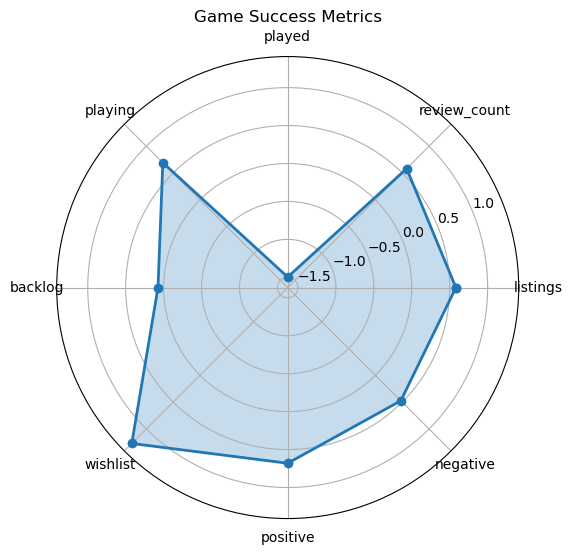

In [129]:
# Create the figure and polar subplot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)

# Plot the radar chart
ax.plot(angles1, values, 'o-', linewidth=2)
ax.fill(angles1, values, alpha=0.25)

# Set the labels for each spoke
ax.set_thetagrids(angles * 180 / np.pi, categories)
plt.title ("Game Success Metrics")

# Show the plot
plt.show()